# PITAS Model Generation Walk-Through

### Import Libraries and Data
<br />
The "intfeat" dataframe comes from pre-processed data containing for each intersection:

- Number of One-Ways: 'numones', integer
- The mean speed of roads at the intersection: 'meanspeed', float
- The maximum speed differential at the intersection: 'maxdiffspeed', float
- The number of roads at the intersection: 'numroad', integer
- The number of uniquely named roads at the intersection: 'uniroad', integer
- If the intersection has stop signs: 'StopSign', Bool
- The number of stop signs per road at the intersection: 'StopPerWay', float
- If the intersection has a traffic light: 'TrafficLight', Bool 
- If the intersection has a traffic light that has a period of Red/Yellow Flashing: 'TrafficFlash', Bool
- The number of signs restricting turns: 'turnrestriction', integer
- The number of signs restricting parking: 'noparking', integer
- The number of signs alerting drivers to upcoming intersections: 'vissigns', integer
- The number of signs for yielding: 'yielding', integer
- The number of 311 complaints about the intersection since 2015: 'Complaints311', integer
- Categorical encoding columns for the zoning of the intersection:
       'Golden_Triangle_', 'Local_Neighborhood_Commercial_',
       'Neighborhood_Industrial', 'Single-Unit_Attached_Residential',
       'Urban_Industrial', 'Hillside__', 'Specially_Planned',
       'Multi-Unit_Residential', 'Urban_Neighborhood_Commercial', 'Parks',
       'Educational/Medical_Institution', 'Two-Unit_Residential',
       'General_Industrial', 'Planned_Unit_Development',
       'Single-Unit_Detached_Residential', 'General_Industrial__',
       'Highway_Commercial', 'Three-Unit_Residential', 'Neighborhood_Office', Bool
- The latitude of the interesection, 'latitude', float
- The longitude of the intersection, 'longitude', float
- An array of the number of accidents from 2004-2017, 'AccOverTime', Numpy Array
- A list of unique road names at the intersection: 'STlist', list
- A string containing all uniqe road names at the intersection: 'STstr', string
- The mean number of accidents at the intersection (2004-2017): 'numacc', float

In [42]:
import os
import numpy as np
import pandas as pd
from six.moves import urllib
import ast

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import pickle

In [43]:
#Import data
path = os.getcwd()
intfeat = pd.read_csv(os.path.dirname(path)+r'/data_checkpoints/ModelDf.csv')
intfeat.set_index('IntCode',inplace=True)

#Fill NaNs, remove unnecessary features, 
intfeat.drop(columns=['numacc','ZipCode'],inplace=True)
intfeat.StopPerWay.fillna(0, inplace=True)
intfeat.TrafficFlash.fillna(0, inplace=True)
intfeat.AccOverTime=intfeat.AccOverTime.apply(lambda x: ast.literal_eval(x))
intfeat.STlist=intfeat.STlist.apply(lambda x: ast.literal_eval(x))
intfeat['numacc']= intfeat.AccOverTime.apply(lambda x: sum(x[9:])/5) #Mean annual accidents 2013-2017
intfeat.drop(columns=['latitude','longitude','AccOverTime','STlist','STstr'],inplace=True)


In [44]:
#Create labels for intersections
intfeat['numacc2']=0
intfeat.numacc2.loc[intfeat.numacc==0.0]=1
intfeat.numacc2.loc[(intfeat.numacc>0.0)&(intfeat.numacc<=2.0)]=2
intfeat.numacc2.loc[(intfeat.numacc>2.0)]=3
intfeat.drop(columns=['numacc'],inplace=True)

### Data Splitting and Cleaning
<br />
We need to generate training and test sets with representative numbers of each classification label and we need to scale the data so that attributes can be compared to one another.


In [45]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(intfeat, intfeat["numacc2"]):
    train_full = intfeat.iloc[train_index]
    test_full = intfeat.iloc[test_index]

print('Training set label proportions:\n',train_full.numacc2.value_counts()/train_full.numacc2.value_counts().sum())
print('Test set label proportions:\n',test_full.numacc2.value_counts()/test_full.numacc2.value_counts().sum())


trainY = train_full.numacc2
train_full.drop(columns=['numacc2'], inplace=True)
testY = test_full.numacc2
test_full.drop(columns=['numacc2'], inplace=True)



Training set label proportions:
 1    0.743171
2    0.237854
3    0.018975
Name: numacc2, dtype: float64
Test set label proportions:
 1    0.743354
2    0.237796
3    0.018850
Name: numacc2, dtype: float64


In [46]:
#Use Standard Scaler to 
scaler = StandardScaler()
train_full = scaler.fit_transform(train_full)
test_full = scaler.fit_transform(test_full)

In [47]:
trainY=trainY.astype('int')
testY=testY.astype('int')

### Classification Model Training and Optimization

A Random Forest Classifier is built using a CV grid search to optimize parameters. 

In [48]:
# Create the parameter grid based on the results of random search 
param_grid2 = {
    'class_weight': ['balanced'],
    'max_depth': [60, 80,100],
    'max_features': [6,8,10],
    'min_samples_leaf': [2,3,4,5],
    'min_samples_split': [12,14,16],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [11]:
grid_search.fit(train_full,trainY)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  6.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'class_weight': ['balanced'], 'max_depth': [60, 80, 100], 'max_features': [6, 8, 10], 'min_samples_leaf': [2, 3, 4, 5], 'min_samples_split': [12, 14, 16], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

The best parameters can then be used to create a new classifier. While not necessary, this step will minimize the memory footprint of the estimator for deployment on the final dashboard.

In [12]:
grid_search.best_params_ 

{'class_weight': 'balanced',
 'max_depth': 80,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 300}

In [49]:
finRF = RandomForestClassifier(class_weight='balanced',n_estimators=300, max_depth=80, min_samples_split=12, min_samples_leaf=2,max_features=6)

In [50]:
finRF.fit(train_full,trainY)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=12, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [ ]:
#Save the model
pickle.dump(finRF, open('RFmod20190726_f.sav', 'wb'))

This pickled model is what is used in the dashboard application. It is unpickled in app.py and implemented from there!

### Model Evaluation

Start by looking at the over all weighted accuracy between the training and test sets:

In [51]:
#Evaluate the fit:
training_predictions = finRF.predict(train_full)

#Use our test set to evaluate the model:
test_predictions = finRF.predict(test_full)

print('Train score: ',finRF.score(train_full,trainY),' Test score: ',finRF.score(test_full,testY))

Train score:  0.8332124728063814  Test score:  0.7684871918801354


In this case, however, Recall is more important (we want to ensure that we not characterizing classifying dangerous intersections as safe, ie, a false negative is more dangerous than a false positive for this problem). To evaluate this, we can look at the Classification Report:

In [52]:
print(classification_report(testY, test_predictions))

              precision    recall  f1-score   support

           1       0.87      0.84      0.85      1538
           2       0.51      0.57      0.54       492
           3       0.47      0.64      0.54        39

   micro avg       0.77      0.77      0.77      2069
   macro avg       0.62      0.68      0.65      2069
weighted avg       0.78      0.77      0.77      2069



We can also look at the (Predicted Label Value - Real Label Value) for the test set. Positive numbers mean that we overestimated the danger of the model (false positive), and negative numbers mean that we underestimated the danger (false negative). Notably, while 10% of classifications are false negatives, there are no cases where we considered a Risk Level 3 intersection as a Risk Level 1 (ie, a differential of -2). 

In [53]:
((test_predictions-testY).value_counts())/((test_predictions-testY).value_counts().sum())

 0    0.768487
 1    0.132431
-1    0.097632
 2    0.001450
Name: numacc2, dtype: float64

Finally, we can display the relative feature importances for our model:

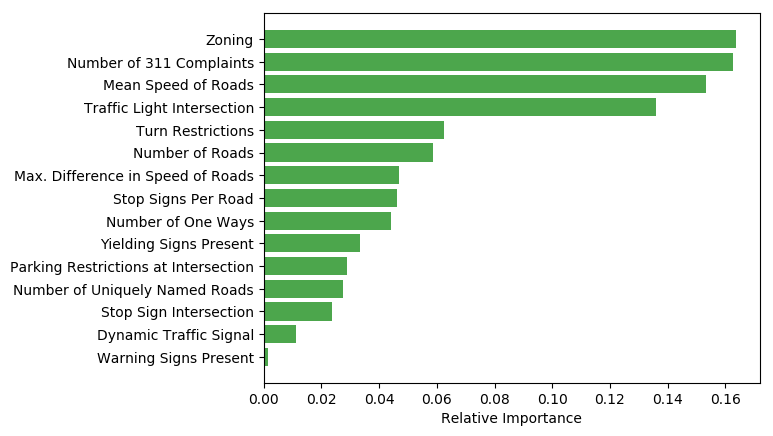

In [78]:
cols2 = ['Number of One Ways','Mean Speed of Roads','Max. Difference in Speed of Roads','Number of Roads',
        'Number of Uniquely Named Roads','Stop Sign Intersection','Stop Signs Per Road','Traffic Light Intersection',
         'Dynamic Traffic Signal','Turn Restrictions','Parking Restrictions at Intersection',
         'Warning Signs Present','Yielding Signs Present','Number of 311 Complaints','Zoning']

feature_importances = pd.DataFrame(list(finRF.feature_importances_[:14])+[sum(finRF.feature_importances_[14:])], index = cols2, 
                                   columns=['Relative Importance']).sort_values('Relative Importance', ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(1,16)

ax.barh(y_pos, feature_importances['Relative Importance'].values, align='center',color='#4CA64C')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importances.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance')

plt.show()